In [295]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    SoftPhongShader,
    MeshRasterizer,  
    HardPhongShader,
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
print(now_str())
print(torch.__version__)
print(torch.version.cuda)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[04/24 18:50:19]
1.4.0
9.2


# Generate .obj manually

#### 2x2

In [2]:
for x in np.arange(-1.0, 1.1, 1):
    for y in np.arange(-1.0, 1.1, 1):
        print('v {:.4f} {:.4f} {:.4f}'.format(x, y, 0))
        print('vn {:.4f} {:.4f} {:.4f}'.format(0, 0, 1))
for x in np.arange(0.0, 1.1, 0.5):
    for y in np.arange(0.0, 1.1, 0.5):
        print('vt {:.4f} {:.4f}'.format(x, y))
for r in range(2):
    for c in range(2):
        i1 = r*3 + c + 1
        i2 = i1 + 1
        i3 = i1 + 3
        i4 = i3 + 1
#         print(i1, i2, i3, i4)
        print('f {}/{}/{} {}/{}/{} {}/{}/{} {}/{}/{}'.format(i1,i1,i1, i3,i3,i3, i4,i4,i4, i2,i2,i2))

v -1.0000 -1.0000 0.0000
vn 0.0000 0.0000 1.0000
v -1.0000 0.0000 0.0000
vn 0.0000 0.0000 1.0000
v -1.0000 1.0000 0.0000
vn 0.0000 0.0000 1.0000
v 0.0000 -1.0000 0.0000
vn 0.0000 0.0000 1.0000
v 0.0000 0.0000 0.0000
vn 0.0000 0.0000 1.0000
v 0.0000 1.0000 0.0000
vn 0.0000 0.0000 1.0000
v 1.0000 -1.0000 0.0000
vn 0.0000 0.0000 1.0000
v 1.0000 0.0000 0.0000
vn 0.0000 0.0000 1.0000
v 1.0000 1.0000 0.0000
vn 0.0000 0.0000 1.0000
vt 0.0000 0.0000
vt 0.0000 0.5000
vt 0.0000 1.0000
vt 0.5000 0.0000
vt 0.5000 0.5000
vt 0.5000 1.0000
vt 1.0000 0.0000
vt 1.0000 0.5000
vt 1.0000 1.0000
f 1/1/1 4/4/4 5/5/5 2/2/2
f 2/2/2 5/5/5 6/6/6 3/3/3
f 4/4/4 7/7/7 8/8/8 5/5/5
f 5/5/5 8/8/8 9/9/9 6/6/6


In [3]:
for x in np.arange(-1.0, 1.1, 0.5):
    for y in np.arange(-1.0, 1.1, 0.5):
        print('v {:.4f} {:.4f} {:.4f}'.format(x, y, 0))
        print('vn {:.4f} {:.4f} {:.4f}'.format(0, 0, 1))
for x in np.arange(0.0, 1.1, 0.25):
    for y in np.arange(0.0, 1.1, 0.25):
        print('vt {:.4f} {:.4f}'.format(x, y))
for r in range(4):
    for c in range(4):
        i1 = r*5 + c + 1
        i2 = i1 + 1
        i3 = i1 + 5
        i4 = i3 + 1
#         print(i1, i2, i3, i4)
        print('f {}/{}/{} {}/{}/{} {}/{}/{} {}/{}/{}'.format(i1,i1,i1, i3,i3,i3, i4,i4,i4, i2,i2,i2))

v -1.0000 -1.0000 0.0000
vn 0.0000 0.0000 1.0000
v -1.0000 -0.5000 0.0000
vn 0.0000 0.0000 1.0000
v -1.0000 0.0000 0.0000
vn 0.0000 0.0000 1.0000
v -1.0000 0.5000 0.0000
vn 0.0000 0.0000 1.0000
v -1.0000 1.0000 0.0000
vn 0.0000 0.0000 1.0000
v -0.5000 -1.0000 0.0000
vn 0.0000 0.0000 1.0000
v -0.5000 -0.5000 0.0000
vn 0.0000 0.0000 1.0000
v -0.5000 0.0000 0.0000
vn 0.0000 0.0000 1.0000
v -0.5000 0.5000 0.0000
vn 0.0000 0.0000 1.0000
v -0.5000 1.0000 0.0000
vn 0.0000 0.0000 1.0000
v 0.0000 -1.0000 0.0000
vn 0.0000 0.0000 1.0000
v 0.0000 -0.5000 0.0000
vn 0.0000 0.0000 1.0000
v 0.0000 0.0000 0.0000
vn 0.0000 0.0000 1.0000
v 0.0000 0.5000 0.0000
vn 0.0000 0.0000 1.0000
v 0.0000 1.0000 0.0000
vn 0.0000 0.0000 1.0000
v 0.5000 -1.0000 0.0000
vn 0.0000 0.0000 1.0000
v 0.5000 -0.5000 0.0000
vn 0.0000 0.0000 1.0000
v 0.5000 0.0000 0.0000
vn 0.0000 0.0000 1.0000
v 0.5000 0.5000 0.0000
vn 0.0000 0.0000 1.0000
v 0.5000 1.0000 0.0000
vn 0.0000 0.0000 1.0000
v 1.0000 -1.0000 0.0000
vn 0.0000 0.0000 1

# Setup

In [4]:
print('torch.cuda.is_available():',torch.cuda.is_available())

device = torch.device("cuda:0")
torch.cuda.set_device(device)
print('----- torch.cuda.empty_cache() -----')

torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

torch.cuda.is_available(): True
----- torch.cuda.empty_cache() -----
torch.cuda.memory_reserved(): 0.00 Mb
torch.cuda.memory_allocated(): 0.00 Mb
torch.cuda.memory_cached(): 0.00 Mb


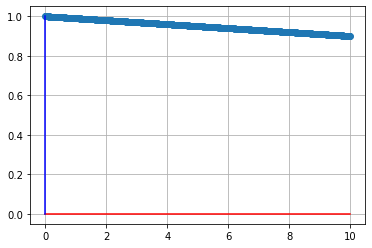

In [5]:
L = 10
x = np.arange(0, L, 0.01)
# y = np.exp(-x/1)
y = -x/100 + 1
plt.figure()
plt.plot(x, y, marker='o')
plt.plot([0, max(x)], [0, 0], c='r')
plt.plot([0, 0], [0, max(y)], c='b')
plt.grid()
plt.show()

In [357]:
image_size = 64
distance = 3   # distance from camera to the object
elevation = 0.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=image_size, 
    blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=1, 
)
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
a_diffuse = 0
a_ambient = 0.2
s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(device)
d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(device)
a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(device)
lights.specular_color = s
lights.diffuse_color = d
lights.ambient_color = a
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)
texture_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
#     shader=TexturedSoftPhongShader(device=device, blend_params=blend_params, lights=lights)
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights, blend_params=blend_params)
)

s = 32
texturemap_shape = (s, s, 1)
np.random.seed(image_size * s)
texturemap_np = np.random.rand(texturemap_shape[0], texturemap_shape[1]).astype(np.float32)*0
texturemap_np = cv2.resize(texturemap_np, (raster_settings.image_size, raster_settings.image_size), interpolation=cv2.INTER_NEAREST)
texturemap_np = np.expand_dims(np.expand_dims(texturemap_np, axis=0), axis=3)
texture_map_torch = torch.from_numpy(texturemap_np).to(device)
texture_map = nn.Parameter(texture_map_torch, requires_grad=False)

# mesh_paths ='./11_data/input/plane_2x2.obj'
# mesh_paths = './11_data/input/tetrahedron.obj'
mesh_paths = './11_data/input/triangle.obj'
verts, faces, aux = load_obj(mesh_paths)
faces_idx = faces.verts_idx

# Initialize each vertex to be white in color.
verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs, verts_rgb=verts_rgb.to(device)).to(device)

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces_idx.to(device)], 
    textures=textures
)

# deform mesh
scale = 0.1
target_vertex = -1
verts = mesh.verts_packed().detach().cpu().numpy()
dverts_target = np.zeros((verts.shape[0], 3)).astype(np.float32)
# dverts_target = (np.random.rand(verts.shape[0], 3).astype(np.float32) - 0.5)*scale
dverts_target = dverts_target + np.array([1.0, 0, 0]).astype(np.float32)
# dverts_target[0, 0] += 0.1
print('dverts: {}, min={:.2f}, max={:.2f}'.format(dverts_target.shape, np.min(dverts_target), np.max(dverts_target)))
dverts_target[..., 2] *= 0
if target_vertex > 0:
    for i in range(dverts_target.shape[0]):
        if i != target_vertex:
            dverts_target[i, :] *= 0
dverts_target = torch.from_numpy(dverts_target).to(device)
mesh_target = mesh.clone()
mesh_target = mesh_target.offset_verts(dverts_target)

silhouete = silhouette_renderer(meshes_world=mesh_target)
print()
# image_rendered, prob = texture_renderer(meshes_world=mesh_target)#
image_rendered = texture_renderer(meshes_world=mesh_target)#

silhouete = silhouete.cpu().numpy().squeeze()
image_rendered = image_rendered.detach().cpu().numpy().squeeze()

# %matplotlib notebook
# x = np.linspace(0, 1, image_size)
# y = np.linspace(0, 1, image_size)
# xv, yv = np.meshgrid(x, y)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# prob = prob.squeeze().detach().cpu().numpy()
# print(xv.shape, yv.shape, prob.shape)
# #ax.set_title('blur_radius={}, sigma={}'.format(raster_settings.blur_radius, blend_params.sigma))
# ax.set_title('blur_radius={}'.format(raster_settings.blur_radius))
# ax.plot_surface(xv, yv, prob, cmap='coolwarm', vmin=0, vmax=1.0)
# plt.show()

dverts: (3, 3), min=0.00, max=1.00



### Generate target image

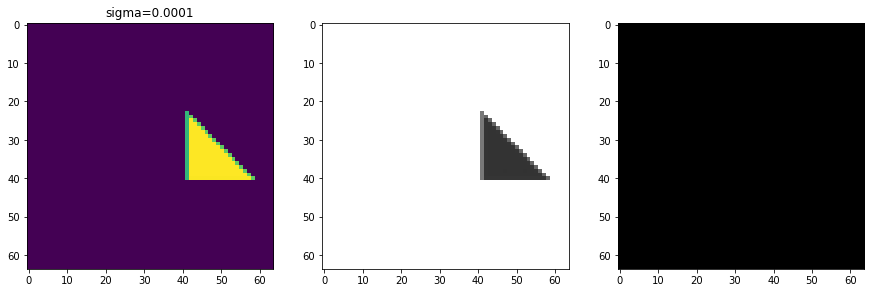

./11_data/input/target_images/target_image_32_0.1.png


In [358]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('sigma={}'.format(blend_params.sigma))
plt.imshow(silhouete[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)

plt.subplot(1, 3, 2)
plt.imshow(image_rendered)

plt.subplot(1, 3, 3)
plt.imshow(texturemap_np.squeeze(), cmap='gray')
plt.show()

save_path = './11_data/input/target_images/target_image_{}_{}.png'.format(s, scale)

import matplotlib
matplotlib.image.imsave(save_path, image_rendered[..., :3], dpi=300)
print(save_path)

# Train

In [359]:
in_path = './11_data/input/target_images/target_image_32_0.1.png'
target_image_np = (imageio.imread(in_path) / 255.0).astype(np.float32)
target_image = torch.from_numpy(target_image_np[..., :3]).unsqueeze(0).to(device)
print('target_image:', target_image.shape, ', min={:.2f}, max={:.2f}'.format(torch.min(target_image), torch.max(target_image)))

target_image: torch.Size([1, 64, 64, 3]) , min=0.20, max=1.00


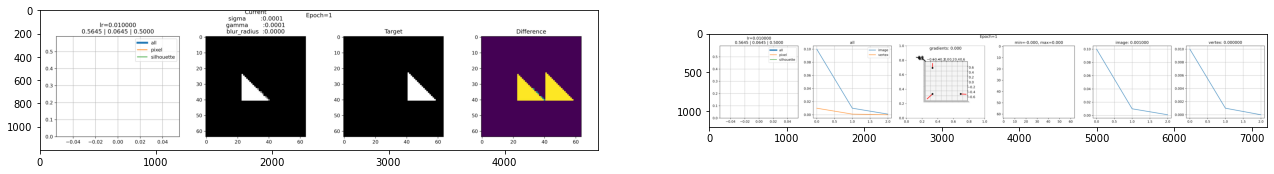

In [364]:
import math
class GaussianLayer(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        
        self.convs = {}
        kernel_size = 3
        sigma = 1
        self.convs[4] = self._get_gaussian_conv2d(kernel_size, sigma, channels=4)
        self.convs[3] = self._get_gaussian_conv2d(kernel_size, sigma, channels=3)
        self.convs[1] = self._get_gaussian_conv2d(kernel_size, sigma, channels=1)

        # Given groups=3, weight of size 3 1 3 3, expected input[1, 512, 512, 4] to have 3 channels, but got 512 channels instead
        
    def forward(self, x, kernel_size, sigma):
        if kernel_size < 3.0:
            return x

        channels = x.shape[-1]
        gaussian_kernel = self._generate_gaussian_kernel(kernel_size=kernel_size, sigma=sigma, channels=channels)
        self.convs[channels].weight.data = gaussian_kernel
        self.convs[channels].padding = int(kernel_size/2)
        
        x = x.transpose(3, 1)
        # gaussian_kernel: (channels, batch, w, h)=(4, 1, 3, 3)
        # x: (batch, channels, w, h)=(1, 4, 512, 512)
        out = self.convs[channels](x)
        out = out.transpose(3, 1)
        return out
    
    def _generate_gaussian_kernel(self, kernel_size, sigma, channels=4):
        # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
        x_cord = torch.arange(kernel_size)
        x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1)

        mean = (kernel_size - 1)/2.
        variance = sigma**2.

        # Calculate the 2-dimensional gaussian kernel which is
        # the product of two gaussian distributions for two different
        # variables (in this case called x and y)
        gaussian_kernel = (1./(2.*math.pi*variance)) * torch.exp(-torch.sum((xy_grid - mean)**2., dim=-1) / (2*variance + 1e-8))
        
#         gaussian_kernel = torch.sum((xy_grid - mean)**2, dim=-1)
        # Make sure sum of values in gaussian kernel equals 1.
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
        # Reshape to 2d depthwise convolutional weight
        gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1).to(self.device)
        return gaussian_kernel
    
    def _get_gaussian_conv2d(self, kernel_size, sigma, channels=4):
        gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, stride=1, padding=int(kernel_size/2), groups=channels, bias=False).to(self.device)
        gaussian_kernel = self._generate_gaussian_kernel(kernel_size=kernel_size, sigma=sigma, channels=channels)
        gaussian_filter.weight.data = gaussian_kernel
        gaussian_filter.weight.requires_grad = False
        return gaussian_filter
    
    
    
class Model(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()

        self.device = device
        self.texture_maps = kwargs.get('texture_maps', None)
        self.mesh = kwargs.get('mesh', None)
        self.target_image = kwargs.get('target_image', None)
        self.target_silhouette = self.target_image.clone().squeeze()[..., 0]
        mask = self.target_silhouette < 1.0
        self.target_silhouette[mask] = 0.0
        self.target_silhouette = 1 - self.target_silhouette
        
        self.dverts = torch.from_numpy(np.zeros((self.mesh.verts_packed().shape), dtype=np.float32)).to(self.device)
        self.dverts = nn.Parameter(self.dverts, requires_grad=True)

        self.renderer, self.sil_renderer = self._init_renderer()
        self.gaussian = GaussianLayer(self.device)
        
        
    def forward(self, kernel_size, sigma, raster_settings, blend_params):
        mesh_deformed = self.mesh.offset_verts(self.dverts)
        image = self.renderer(meshes_world=mesh_deformed, raster_settings=raster_settings, blend_params=blend_params)
        
        silhouette = self.sil_renderer(meshes_world=mesh_deformed, texture_maps=model.mesh.textures._maps_padded.clone(), raster_settings=raster_settings, blend_params=blend_params)
        silhouette = image.clone().detach().squeeze()[..., 3]
        
#         mask = silhouette < 1.0
#         silhouette[mask] = 0.0
        if kernel_size > 1.0:
#             image = self.gaussian(image, kernel_size=kernel_size, sigma=sigma)
#             target_image = self.gaussian(self.target_image, kernel_size=kernel_size, sigma=sigma)
#             target_silhouette = self.gaussian(self.target_silhouette.unsqueeze(-1).unsqueeze(0), kernel_size=kernel_size, sigma=sigma)
            target_image = self.target_image
            target_silhouette = self.target_silhouette
        else:
            target_image = self.target_image
            target_silhouette = self.target_silhouette
        loss_pixels = torch.mean(torch.abs(image[..., :3] - target_image))
        loss_silhouette = 0.5*self._iou(silhouette, self.target_silhouette)
#         loss_silhouette = torch.zeros(1)[0]
        loss = loss_pixels + loss_silhouette
        loss_dict = {'all': loss, 'pixel': loss_pixels, 'silhouette': loss_silhouette}
        image_dict = {'rgba': image, 'silhouette': silhouette, 'target_image': target_image, 'target_silhouette': target_silhouette}
        return image_dict, loss_dict
    
    def _iou(self, S1, S2):
        S1S2 = torch.mul(S1, S2)
        return torch.mean(1.0 - torch.sum(torch.abs(S1S2)) / torch.sum(torch.abs(S1+S2-S1S2)))
        
    def _init_renderer(self):
        global image_size
        distance = 3   # distance from camera to the object
        elevation = 0.0   # angle of elevation in degrees
        azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 
        R, T = look_at_view_transform(distance, elevation, azimuth, device=self.device)
        cameras = OpenGLPerspectiveCameras(device=self.device, R=R, T=T)
        blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        raster_settings = RasterizationSettings(
            image_size=image_size, 
            blur_radius=0.001, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
            faces_per_pixel=1, 
        )
        lights = PointLights(device=self.device, location=((2.0, 2.0, -2.0),)).to(self.device)
        a_diffuse = 0.0
        a_ambient = 0.2
        s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(self.device)
        d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(self.device)
        a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(self.device)
        lights.specular_color = s
        lights.diffuse_color = d
        lights.ambient_color = a
        
        rasterizer = MeshRasterizer(cameras=cameras,raster_settings=raster_settings)
        texture_renderer = MeshRenderer(
            rasterizer=rasterizer,
#             shader=TexturedSoftPhongShader(device=self.device, blend_params=blend_params, lights=lights)
            shader=SoftPhongShader(device=self.device, lights=lights, blend_params=blend_params)
        )
            
        silhouette_renderer = MeshRenderer(
            rasterizer=rasterizer,
            shader=SoftSilhouetteShader(blend_params=blend_params)
        )
        
        return texture_renderer, silhouette_renderer

def render_plots(out_dir, e, losses, lr, image_curr, target_image, texture_map, model, raster_settings, blend_params):
    fig, ax = plt.subplots(1, 6, figsize=(24, 4), tight_layout=True)
    ax[5].grid('off')
    ax[5].axis('off')
    loss_all = losses['all']
    loss_pixel = losses['pixel']
    loss_silhouette = losses['silhouette']
    ax[0].plot(loss_all, linewidth=4)
    ax[0].plot(loss_pixel)
    ax[0].plot(loss_silhouette)
    ax[0].legend(['all', 'pixel', 'silhouette'])
    ax[0].set_title('lr={:.6f}\n{:.4f} | {:.4f} | {:.4f}'.format(lr, loss_all[-1], loss_pixel[-1], loss_silhouette[-1]))
    ax[0].set_ylim(bottom=0)
    ax[0].grid()
    
    sigma = blend_params.sigma
    gamma = blend_params.gamma
    blur_radius = raster_settings.blur_radius
    img_np = image_curr.detach().squeeze().cpu().numpy()
    img_cur = img_np[..., :3]
    ax[1].imshow(img_np, cmap='gray')
    ax[1].set_title('Current\n{:<13}:{:.4f}\n{:<13}:{:.4f}\n{:<13}:{:.4f}'.format('sigma', sigma, 'gamma', gamma, 'blur_radius', blur_radius))
    
    img_tar = target_image.detach().squeeze().cpu().numpy()
    ax[2].imshow(img_tar, cmap='gray')
    ax[2].set_title('Target')
    
    diff = np.clip(img_tar - img_cur, a_min=0.0, a_max=1.0)
    ax[3].imshow(diff)
    ax[3].set_title('Difference')
    
    ax[4].imshow(texture_map.detach().squeeze().cpu().numpy(), cmap='gray')
    ax[4].set_title('Texturemap')

    ax[5] = fig.add_subplot(166, projection='3d')
    # image gradient
#     grad = image_curr.grad.detach().cpu().numpy()
#     print(grad)
    # vertex gradient
    dverts = model.dverts.grad.detach().cpu().numpy()
    dverts_norm = np.linalg.norm(dverts)
    verts = model.mesh.verts_packed().detach().cpu().numpy()
    ax[5].set_title('gradients: {:.3f}'.format(dverts_norm))
    ax[5].quiver(verts[:,0], verts[:,1], verts[:,2], dverts[:,0], dverts[:,1], dverts[:,2], length=5, lw=2, arrow_length_ratio=0.1, color='r')
    ax[5].view_init(elev=-90, azim=0)
    L = 0.75
    ax[5].set_xlim([-L, L])
    ax[5].set_ylim([-L, L])
    ax[5].set_zlim([-L, L])
    plt.suptitle('Epoch={}'.format(e))
    
    out_path = out_dir + '/plot_{}.png'.format(e)
    plt.savefig(out_path, dpi=300)
    plot_image = imageio.imread(out_path)
    plt.close('all')
    
    return plot_image

def render_plots_simple(out_dir, e, losses, lr, image_curr, target_image, raster_settings, blend_params):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4), tight_layout=True)
    loss_all = losses['all']
    loss_pixel = losses['pixel']
    loss_silhouette = losses['silhouette']
    ax[0].plot(loss_all, linewidth=4)
    ax[0].plot(loss_pixel)
    ax[0].plot(loss_silhouette)
    ax[0].legend(['all', 'pixel', 'silhouette'])
    ax[0].set_title('lr={:.6f}\n{:.4f} | {:.4f} | {:.4f}'.format(lr, loss_all[-1], loss_pixel[-1], loss_silhouette[-1]))
    ax[0].set_ylim(bottom=0)
    ax[0].grid()
    
    sigma = blend_params.sigma
    gamma = blend_params.gamma
    blur_radius = raster_settings.blur_radius
    img_np = image_curr.detach().squeeze().cpu().numpy()
    if len(img_np.shape) > 2:
        img_cur = img_np[..., :3]
    else:
        img_cur = img_np
    ax[1].imshow(img_np, cmap='gray')
    ax[1].set_title('Current\n{:<13}:{:.4f}\n{:<13}:{:.4f}\n{:<13}:{:.4f}'.format('sigma', sigma, 'gamma', gamma, 'blur_radius', blur_radius))
    
    img_tar = target_image.detach().squeeze().cpu().numpy()
    ax[2].imshow(img_tar, cmap='gray')
    ax[2].set_title('Target')
    
    diff = np.clip(np.abs(img_tar - img_cur), a_min=0.0, a_max=1.0)
    ax[3].imshow(diff)
    ax[3].set_title('Difference')
    
    plt.suptitle('Epoch={}'.format(e))
    out_path = out_dir + '/plot.png'
    plt.savefig(out_path, dpi=300)
    plot_image = imageio.imread(out_path)
    plt.close('all')
    
    return plot_image

def render_grads(out_dir, e, losses, lr, model, grads, image_grad, raster_settings, blend_params):
    keys = list(grads.keys())
    n_grads = len(keys)
    offset_i = 4
    fig, ax = plt.subplots(1, offset_i+n_grads, figsize=((offset_i+n_grads)*4, 4), tight_layout=True)
    
    loss_all = losses['all']
    loss_pixel = losses['pixel']
    loss_silhouette = losses['silhouette']
    ax[0].plot(loss_all, linewidth=4)
    ax[0].plot(loss_pixel)
    ax[0].plot(loss_silhouette)
    ax[0].legend(['all', 'pixel', 'silhouette'])
    ax[0].set_title('lr={:.6f}\n{:.4f} | {:.4f} | {:.4f}'.format(lr, loss_all[-1], loss_pixel[-1], loss_silhouette[-1]))
    ax[0].set_ylim(bottom=0)
    ax[0].grid()
    
    ax[2] = fig.add_subplot(1, (offset_i+n_grads), 3, projection='3d')
    dverts_grad = model.dverts.grad.detach().cpu().numpy()
    dverts_norm = np.linalg.norm(dverts_grad)
    dverts = dverts_grad / dverts_norm * 0.08
    verts = model.mesh.verts_packed().detach().cpu().numpy()
    ax[2].set_title('gradients: {:.3f}'.format(dverts_norm))
    ax[2].quiver(verts[:,0], verts[:,1], verts[:,2], dverts[:,0], dverts[:,1], dverts[:,2], length=5, lw=2, arrow_length_ratio=0.1, color='r')
    ax[2].scatter(verts[:,0], verts[:,1], verts[:,2], c='k')
    ax[2].view_init(elev=-90, azim=0)
    L = 0.75
    ax[2].set_xlim([-L, L])
    ax[2].set_ylim([-L, L])
    ax[2].set_zlim([-L, L])
    
    image_grad = image_grad.detach().squeeze().cpu().numpy()
    max_0 = np.max(image_grad, axis=0)
    max_1 = np.max(max_0, axis=0)
    min_0 = np.min(image_grad, axis=0)
    min_1 = np.min(min_0, axis=0)
    vmin = np.min(image_grad)
    vmax = np.max(image_grad)
    ax[3].imshow(image_grad, vmin=vmin, vmax=vmax)
    ax[3].set_title('min={:.3f}, max={:.3f}'.format(vmin, vmax))
    
    legends = []
    for i in range(offset_i, n_grads + offset_i):
        vals = grads[keys[i-offset_i]]
        ax[1].plot(vals)
        ax[i].plot(vals)
        legends.append(keys[i-offset_i])
        ax[i].set_title('{}: {:.6f}'.format(keys[i-offset_i], vals[-1]))
        ax[i].grid()
    ax[1].legend(legends)
    ax[1].set_title('all')
    ax[1].grid()
    
    plt.suptitle('Epoch={}'.format(e))
    out_path = out_dir + '/plot.png'
    plt.savefig(out_path, dpi=300)
    plot_image = imageio.imread(out_path)
    plt.close('all')
    
    return plot_image 
model = Model(device=device, mesh=mesh, texture_maps=texture_map, target_image=target_image)

blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
            image_size=image_size, 
            blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
            faces_per_pixel=1, 
)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
losses = {'all': [], 'pixel': [], 'silhouette': []}
kernel_size = 0
sigma = 9

optimizer.zero_grad()
image_dict, loss_dict = model(kernel_size=kernel_size, sigma=sigma, raster_settings=raster_settings, blend_params=blend_params)
for k, v in loss_dict.items():
    vv = v.detach().cpu().numpy()
    losses[k].append(vv)

loss = loss_dict['all']
image_dict['rgba'].retain_grad()
loss.backward()

optimizer.step()
# params = list(model.parameters())
# for param in params:
#     print(param.shape)
# image_grad = image_dict['rgba'].grad
# image_grad = image_grad.detach().squeeze().cpu().numpy()
# plt.figure()
# plt.imshow(image_grad)
# plt.show()
#print(model.dverts.grad.shape)
    
image = image_dict['silhouette']
out_dir = './11_data/output'
out_path = out_dir + '/plot.png'
# plot_image = render_plots(out_dir, 1, losses, 0.01, image, image_dict['target_image'], texture_map, model, raster_settings=raster_settings, blend_params=blend_params)
image_grad = image_dict['rgba'].grad
grads = {'image': [0.1, 0.01, 0.001], 'vertex': [0.01, 0.001]}
grads['vertex'].append(np.linalg.norm(model.dverts.grad.detach().cpu().numpy()))
plot_image = render_plots_simple(out_dir, 1, losses, 0.01, image, image_dict['target_silhouette'], raster_settings=raster_settings, blend_params=blend_params)
plot_grads = render_grads(out_dir, 1, losses, 0.01, model, grads, image_grad, raster_settings=raster_settings, blend_params=blend_params)
fig, ax = plt.subplots(1, 2, figsize=(22, 11))
ax[0].imshow(plot_image)
ax[1].imshow(plot_grads)
plt.show()

# silhouettes
# curr_silhouette = image_dict['silhouette'].detach().squeeze().cpu().numpy()
# target_silhouette = image_dict['target_silhouette'].detach().squeeze().cpu().numpy()
# fig, ax = plt.subplots(1, 2, figsize=(4, 2))
# ax[0].imshow(target_silhouette)
# ax[0].set_title(target_silhouette.shape)
# ax[1].imshow(curr_silhouette)
# ax[1].set_title(curr_silhouette.shape)
# plt.show()

1.0 0.0


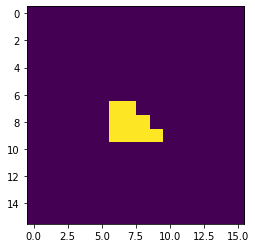

In [361]:
weights_np = weights.detach().squeeze().cpu().numpy()
plt.figure()
plt.imshow(weights_np)
print(np.max(weights_np), np.min(weights_np))
plt.show()

Log output: ./11_data/output/log_20200424.txt


<ipython-input-365-c4f006bbfa67>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(1000000000))


torch.Size([1, 64, 64, 4]) , tensor(8.1380e-05, device='cuda:0')


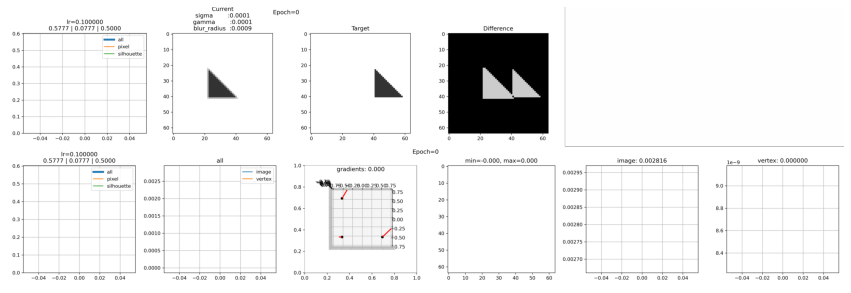

torch.Size([1, 64, 64, 4]) , tensor(8.1380e-05, device='cuda:0')


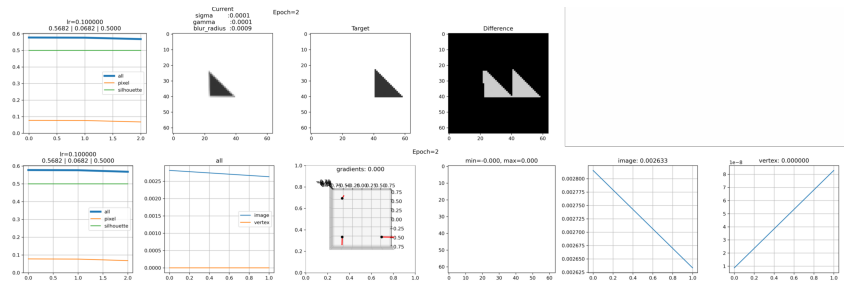

torch.Size([1, 64, 64, 4]) , tensor(8.1380e-05, device='cuda:0')


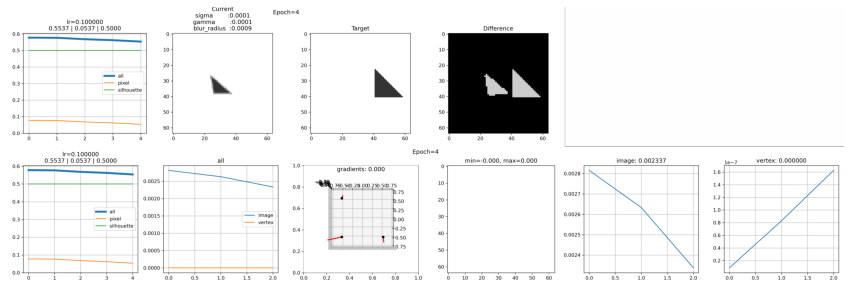

torch.Size([1, 64, 64, 4]) , tensor(8.1380e-05, device='cuda:0')


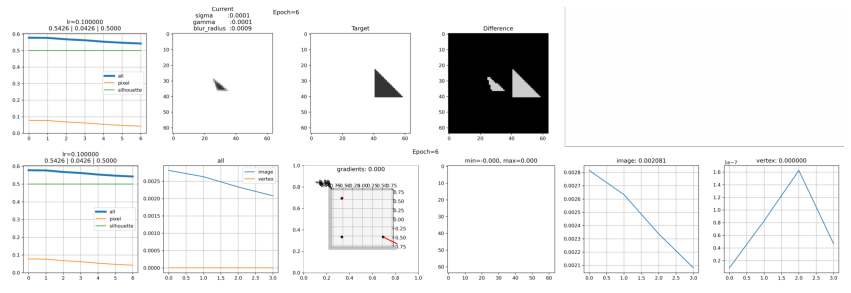

torch.Size([1, 64, 64, 4]) , tensor(8.1380e-05, device='cuda:0')


KeyboardInterrupt: 

In [365]:
%matplotlib inline
from torch.optim.lr_scheduler import ReduceLROnPlateau
out_dir = './11_data/output'
gif_path = out_dir + '/plots.gif'
out_path = out_dir + '/plot.png'
model = Model(device=device, mesh=mesh, texture_maps=texture_map, target_image=target_image)
texture_map = model.mesh.textures._maps_padded.clone()

now = datetime.now()
hour = str(now.hour)
minute = str(now.minute)
date_str = '{}{:>02}{:>02}'.format(now.year, now.month, now.day)
log_path = out_dir + '/log_{}.txt'.format(date_str)
__output_log(log_path, '========== {} Start ==========================\n'.format(date_str))
print('Log output: {}'.format(log_path))

n_epochs = 1000

lr = 0.1
gauss_kernel_size = 0
gauss_sigma = 64
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimize = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
loop = tqdm_notebook(range(1000000000))

images = []
losses = {'all': [], 'pixel': [], 'silhouette': []}
grads = {'image': [], 'vertex': []}
latest_states = {}
sigma = 1e-4
for e in loop:
    t0 = time.time()
    show_image = (e % 2 == 0)
    lr_curr = optimizer.param_groups[0]['lr']

    optimizer.zero_grad()
    
    if e > 0 and e % 50 == 0:
        sigma = max(1e-4, sigma*0.5)
        gauss_kernel_size = max(0, int(gauss_kernel_size*0.5))
        gauss_sigma = max(1.0, gauss_sigma*0.5)
        if gauss_kernel_size % 2 == 0:
            gauss_kernel_size += 1
        
    blend_params = BlendParams(sigma=sigma, gamma=1e-4)
    raster_settings = RasterizationSettings(
                image_size=image_size, 
                blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
                faces_per_pixel=1, 
    )
    image_dict, loss_dict = model(kernel_size=gauss_kernel_size, sigma=gauss_sigma, raster_settings=raster_settings, blend_params=blend_params)
    for k, v in loss_dict.items():
        losses[k].append(v)
    if show_image:
        image_dict['rgba'].retain_grad()
    loss = loss_dict['all']
    loss_pixel = loss_dict['pixel']
    loss_sil = loss_dict['silhouette']
    loss.backward()
    optimizer.step()
    
    loop.set_description('[{}/{}] loss({:.4f}, {:.4f}, {:.4f})'.format(e+1, len(loop), loss_dict['all'].data, loss_dict['pixel'], loss_dict['silhouette']))

    t1 = time.time()
    mb_alloc = torch.cuda.memory_allocated() * 0.000001
    mb_cached = torch.cuda.memory_cached() * 0.000001
    now = datetime.now()
    hour = str(now.hour)
    minute = str(now.minute)
    second = str(now.second)
    now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
    __output_log(log_path, '{} | {:03} | {:.2f}s | lr={:.8f} | loss(all={:.6f}, pixel={:.6f}, sil={:.6f} | GPU_allocated({:,.2f}Mb) | GPU_cached({:,.2f}Mb)\n'.format(now_str, e+1, t1-t0, lr, loss, loss_pixel, loss_sil, mb_alloc, mb_cached))
        
    if show_image:
        image = image_dict['rgba']
        image_grad = image_dict['rgba'].grad
        print(image_grad.shape, ',', torch.max(image_grad))
        grads['vertex'].append(np.linalg.norm(model.dverts.grad.detach().cpu().numpy()))
        grads['image'].append(np.linalg.norm(image_grad.detach().cpu().numpy()))
        
        plot_image = render_plots_simple(out_dir, e, losses, lr, image, image_dict['target_image'], raster_settings=raster_settings, blend_params=blend_params)
        plot_grads = render_grads(out_dir, e, losses, lr, model, grads, image_grad, raster_settings=raster_settings, blend_params=blend_params)
        plot_image = np.hstack([plot_image, np.ones((plot_grads.shape[0], plot_grads.shape[1]-plot_image.shape[1], plot_grads.shape[2]))])
        gif_out = np.vstack([plot_image, plot_grads])
        gif_out_pil = Image.fromarray(np.uint8(gif_out))
        images.append(gif_out_pil)
        images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=250, loop=0)
        
        plt.figure(figsize=(15, 6))
        plt.gca().grid('off')
        plt.gca().axis('off')
        plt.imshow(images[-1], vmin=0, vmax=255)
        out_path = out_dir + '/plot_{}.png'.format(e)
        plt.savefig(out_path, dpi=300)
        plt.show()
        plt.close('all')
    #scheduler.step(loss)
    if lr_curr < 2e-8:
        print('lr={}. BREAK'.format(lr_curr))
        break
    if e > 200:
        print('e={}. BREAK'.format(e))
        break
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=300, loop=0)
print('gif saved:', gif_path)

In [308]:
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=300, loop=0)